In [112]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from ellipse import LsqEllipse
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from skimage import io
import matplotlib.pyplot as plt
import math
import pickle
import statistics
from statistics import mean
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
import pickle

In [116]:
import sys
sys.path.append('.')  
import speckle
from speckle.inference.read_in_data import *
from speckle.inference.correlation_heatmap import *
from speckle.inference.calculating_tau import *
from speckle.inference.dedrift import *

In [3]:
def compute_g2t_wo_kernel(px,laglist_g2t):
    intensity=[]
    for t in range(0,img.shape[0],1):
        intensity.append(img[t][px[0],px[1]])
        
    g2t=[]
    for lag in laglist_g2t:
        numerator_sum=0
        denumerator_sum_1=0
        denumerator_sum_2=0
        max_t_range=len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator_sum=numerator_sum+int(intensity[t])*int(intensity[t+lag])
            denumerator_sum_1=denumerator_sum_1+int(intensity[t])
            denumerator_sum_2=denumerator_sum_2+int(intensity[t+lag])
        numerator=numerator_sum/max_t_range
        denumerator_1=denumerator_sum_1/max_t_range
        denumerator_2=denumerator_sum_2/max_t_range
        g2t.append((numerator/denumerator_1/denumerator_2)-1)
    return g2t

# Viscosity of 0.05% glycerol (4 uL glycerol + 196 uL)

viscosity from Rheometer data: 0.588 Pa*S

In [58]:
#expected D
kb=1.380649*10**(-23) # J*K^(-1)
T=300 # K
eta=0.59 # Pa*S
r=52*10**(-9) # m
D=kb*T/(6*math.pi*eta*r) #m^2/s
print(D) #m^2/s

7.16222663053723e-15


viscosity measured using DLS is 0.6498021636129446 Pa*s

# 0.05% 100nm in diameter PS beads in glycerol

## 10x Objective

In [5]:
video_time_length=30 #s
imgname='0p05ps_beads_inglycerol_405laser_10xobj_0p52au_30s_2avg'
foldername='/Volumes/WENYUN WANG/20221129/0p05_PSbeads_in_glycerol/'

In [6]:
# read the image stack
img = io.imread(foldername+imgname+'.tif')
frame_number=img.shape[0]
img_height=img.shape[1]
img_width=img.shape[2]
framespeed=video_time_length/frame_number

In [7]:
print(framespeed)

0.005857087075361187


In [8]:
laglist_g2t=range(0,500,1)
averaged_g2t=[]
for y in range(1,19,1):
    for x in range(10,40,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        averaged_g2t.append(g2t)

In [9]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg_temperal_2d.p',"wb"))

In [12]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg_temperal_2d.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

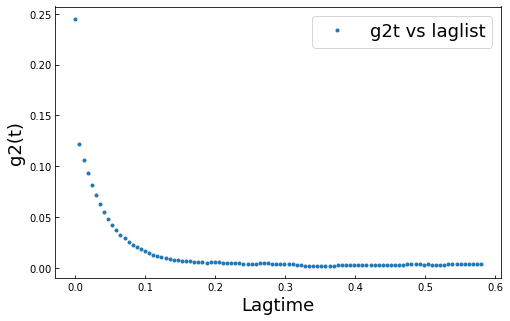

In [13]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:100],average_g2t[0:100],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

tau is: 0.044338694159703027
y = -22.55366 * x + -1.97391


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


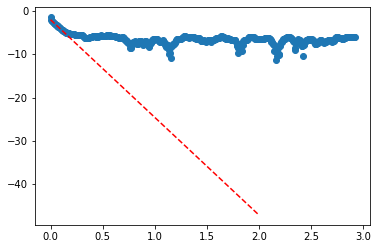

R square is 0.9999999999999998


In [20]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(average_g2t),lagtime_g2t,1,3, True)

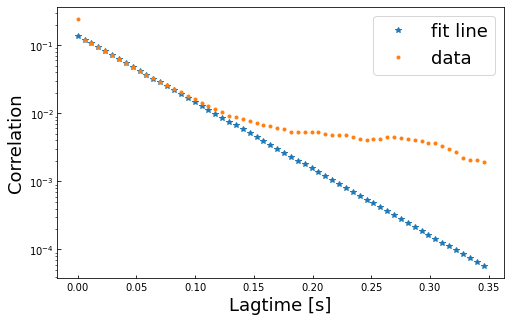

In [21]:
reconstruct(lagtime_g2t[0:60],plateau,np.array(average_g2t[0:60]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [22]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

5.4759148335391876e-15


# TRC

In [30]:
# for one pixel
def TRC(pixel,kernel_size_y, kernel_size_x, t_interest, tau_interest):
    correlation_2d=np.zeros((len(t_interest),len(tau_interest)))
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size_y, 2*kernel_size_x))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size_y, y+kernel_size_y)):
        for xindex, j in enumerate(range(x-kernel_size_x, x+kernel_size_x)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i,j]
    value=(2*kernel_size_x)*(2*kernel_size_y)
    intensity=np.reshape(intensity,(total_tlength, value))
    print(intensity.shape)
    # compute correlation
    for t in t_interest:
        for tau in tau_interest:
            numerator=[]
            denum1=[]
            denum2=[]
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
            correlation_2d[t,tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
            correlation_2d[t,tau]=correlation_2d[t,tau]/correlation_2d[t,0]
    
    return correlation_2d

In [45]:
laglist_g2t=range(0,50,1)
t_range=range(0,500,1)
TRC_corr=TRC([10,225],10,225,t_range,laglist_g2t)

(550, 9000)


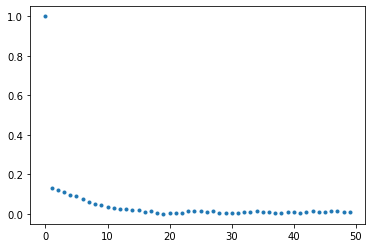

In [114]:
plt.plot(TRC_corr[10,:],'.')

tau is: 0.03699015987053151
y = -27.03422 * x + -1.74062


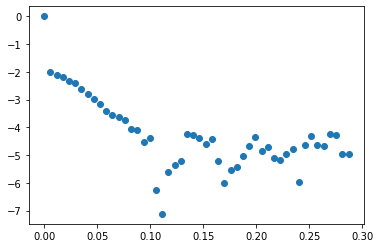

R square is 0.983923499193227


In [59]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(TRC_corr[10,:]),lagtime_g2t,1,13, True)

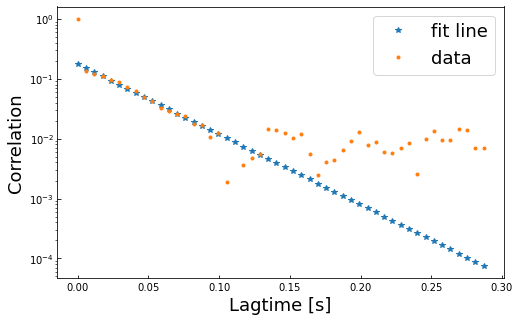

In [60]:
reconstruct(lagtime_g2t[0:50],plateau,np.array(TRC_corr[10,:]),a,b)
plt.yscale("log")

In [61]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

6.563770308067784e-15


# Average over spatial and temporal

In [65]:
# for one pixel
def spatial_temporal(pixel,kernel_size_y, kernel_size_x, t_interest, tau_interest):
    correlation=np.zeros(len(tau_interest))
    
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size_y, 2*kernel_size_x))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size_y, y+kernel_size_y)):
        for xindex, j in enumerate(range(x-kernel_size_x, x+kernel_size_x)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i,j]
    value=(2*kernel_size_x)*(2*kernel_size_y)
    intensity=np.reshape(intensity,(total_tlength, value))
    print(intensity.shape)
    # compute correlation

    for tau in tau_interest:
        numerator=[]
        denum1=[]
        denum2=[]
        for t in t_interest:
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
        correlation[tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
        correlation[tau]=correlation[tau]/correlation[0]

    return correlation

In [67]:
laglist_g2t=range(0,50,1)
t_range=range(0,500,1)
spatemp_corr=spatial_temporal([10,225],10,225,t_range,laglist_g2t)

(550, 9000)


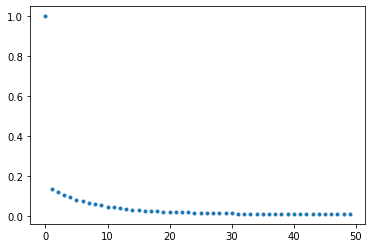

In [73]:
plt.plot(spatemp_corr[:],'.')

tau is: 0.047474694258017223
y = -21.06385 * x + -1.89109


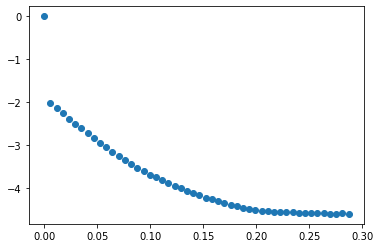

R square is 0.9999877987312753


In [77]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(spatemp_corr[:]),lagtime_g2t,1,4, True)

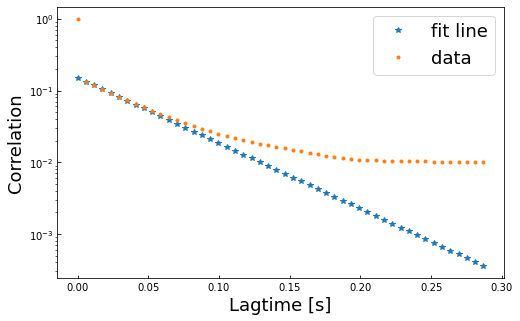

In [78]:
reconstruct(lagtime_g2t[0:50],plateau,np.array(spatemp_corr[:]),a,b)
plt.yscale("log")

In [79]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

5.114196454416839e-15


# line scanning

In [104]:
def compute_g2t_wo_kernel_line(img,x,laglist_g2t):
    intensity=[]
    for t in range(0,img.shape[1],1):
        intensity.append(img[0,t,0,0,0,x,0])
    plt.plot(intensity[0:50],'-')
        
    g2t=[]
    for lag in laglist_g2t:
        numerator_sum=0
        denumerator_sum_1=0
        denumerator_sum_2=0
        max_t_range=len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator_sum=numerator_sum+int(intensity[t])*int(intensity[t+lag])
            denumerator_sum_1=denumerator_sum_1+int(intensity[t])
            denumerator_sum_2=denumerator_sum_2+int(intensity[t+lag])
        numerator=numerator_sum/max_t_range
        denumerator_1=denumerator_sum_1/max_t_range
        denumerator_2=denumerator_sum_2/max_t_range
        g2t.append((numerator/denumerator_1/denumerator_2)-1)
    return g2t

In [105]:
video_time_length=10
imgname='0p05ps_beads_inglycerol_405laser_10xobj_0p52au_10s_2avg_linescan_bidirc'
foldername='/Volumes/WENYUN WANG/20221129/0p05_PSbeads_in_glycerol/'

In [106]:
import czifile
from skimage import io

img = czifile.imread(foldername+imgname+".czi")

In [107]:
img.shape

(1, 34155, 1, 1, 1, 512, 1)

In [108]:
img[0,3,0,0,0,9,0]

26

In [109]:
# read the image stack
frame_number=img.shape[1]
img_width=img.shape[5]
framespeed=video_time_length/frame_number

In [110]:
img.shape

(1, 34155, 1, 1, 1, 512, 1)

KeyboardInterrupt: 

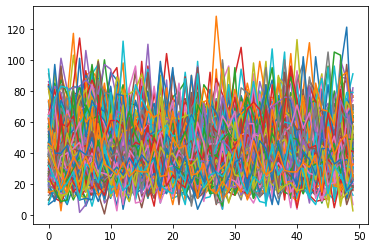

In [111]:
laglist_g2t=range(0,1000,1)
averaged_g2t=[]
for x in range(1,150,1):
    g2t=compute_g2t_wo_kernel_line(img,x,laglist_g2t)
    averaged_g2t.append(g2t)

In [ ]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg.p',"wb"))

In [ ]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:3000],average_g2t[0:3000],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

In [ ]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(average_g2t),lagtime_g2t,1,10, True)

In [ ]:
reconstruct(lagtime_g2t[0:60],plateau,np.array(average_g2t[0:60]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [ ]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)